<a href="https://colab.research.google.com/github/GKS07/Classification_Projects/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting the Kaggle API
**Downloading and unzipping the data**

In [ ]:
# uploading the kaggle jason file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gau7rav","key":"50c43821a9373319816f6b8412be5c26"}'}

In [ ]:
# making and changing the directory

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
# verifying jason content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 Oct 20 07:23 kaggle.json
{"username":"gau7rav","key":"50c43821a9373319816f6b8412be5c26"}

In [ ]:
# install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 16.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for lxml
ERROR: Could not build wheels for lxml, which is required to install pyproject.toml-based projects


In [ ]:
# Download a dataset
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 94% 82.0M/86.8M [00:03<00:00, 27.7MB/s]
100% 86.8M/86.8M [00:03<00:00, 28.0MB/s]


In [ ]:
# making the directory
! mkdir Brain_tumor_dataset

In [ ]:
# unzipping the file.
! unzip brain-tumor-classification-mri.zip -d Brain_tumor_dataset

In [ ]:
import tensorflow as tf
print('TensorFlow version:',tf.__version__)

TensorFlow version: 2.13.0


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Exploring the data

we have a images of diffrent stages of **Brain Tumor** , we will use CNN to train and classify the diffrent stages of Brain tumor.

4 classes:
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


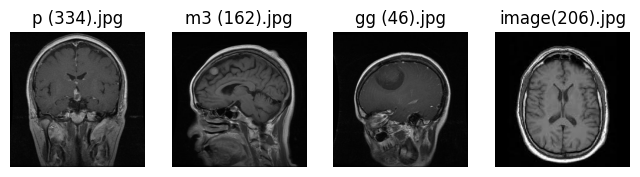

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

# The images are in the data/shapes folder
data_folder = '/content/Brain_tumor_dataset/Training'

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

# Preprocessing the data

Before traning the model we will prepare the data. dividing  the feature values by 255 will normalize the as floating point between 0 and 1, and we'll split the data so that we can use 70% of it to train the model, and hold back 30% to validate it. When loading the data, the data generator will assign "hot-encoded" numeric labels to indicate which class each image belongs to based on the subfolders in which the data is stored. In this case, there are three subfolders - glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor, so the labels will consist of four 0 or 1 values indicating which of these classes is associated with the image - for example the label [0 1 0 0] indicates that the image belongs to the second class (meningioma_tumor).

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 2011 images belonging to 4 classes.
Preparing validation dataset...
Found 859 images belonging to 4 classes.
Data generators ready


# Defining the CNN Model
This is Multiclass Classification Problem

In [ ]:
# Define a CNN classifier network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# And another set
model.add(Conv2D(64, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

#Traning the model with Image data

In [ ]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size ,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size ,
    epochs = num_epochs)

Epoch 1/15
67/67 [==============================] - 8s 75ms/step - loss: 1.0961 - accuracy: 0.5275 - val_loss: 1.3966 - val_accuracy: 0.4286
Epoch 2/15
67/67 [==============================] - 6s 92ms/step - loss: 0.7507 - accuracy: 0.7017 - val_loss: 1.2063 - val_accuracy: 0.4821
Epoch 3/15
67/67 [==============================] - 7s 101ms/step - loss: 0.5841 - accuracy: 0.7733 - val_loss: 1.3272 - val_accuracy: 0.4869
Epoch 4/15
67/67 [==============================] - 5s 73ms/step - loss: 0.5510 - accuracy: 0.7839 - val_loss: 1.2375 - val_accuracy: 0.5214
Epoch 5/15
67/67 [==============================] - 7s 112ms/step - loss: 0.3755 - accuracy: 0.8627 - val_loss: 1.2095 - val_accuracy: 0.5905
Epoch 6/15
67/67 [==============================] - 5s 73ms/step - loss: 0.2529 - accuracy: 0.9026 - val_loss: 1.2879 - val_accuracy: 0.5750
Epoch 7/15
67/67 [==============================] - 7s 107ms/step - loss: 0.1784 - accuracy: 0.9379 - val_loss: 1.7252 - val_accuracy: 0.6036
Epoch 8/15

Plotting the Traning and Validation Loss

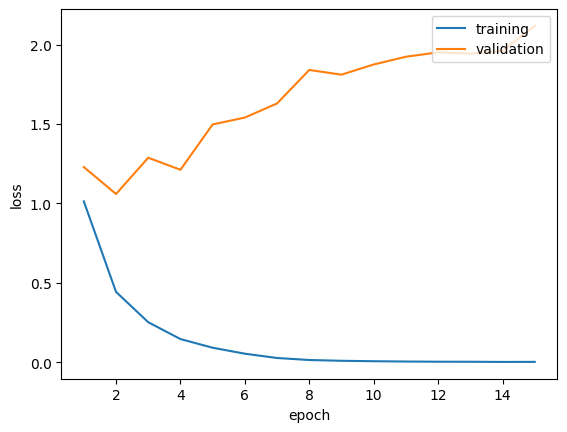

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#Plotting a **Confusion Matrix**

Generating predictions from validation data...
1/1 [==============================] - 0s 109ms/step


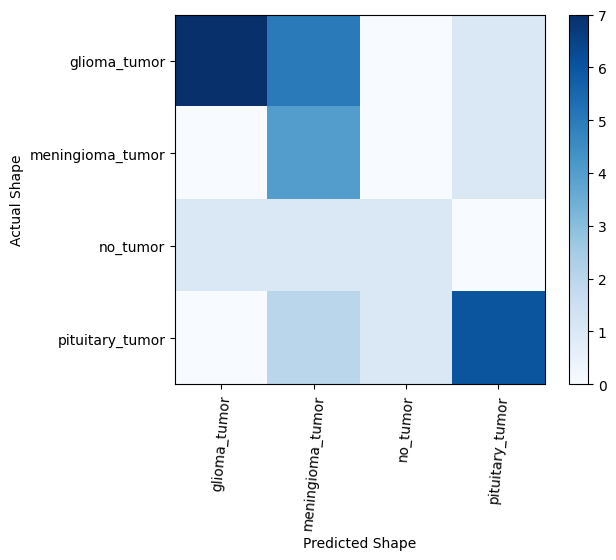

In [ ]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

#Saving the model

In [ ]:
# Save the trained model
modelFileName = '/content/drive/MyDrive/Brain_tumor_model.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as /content/drive/MyDrive/Brain_tumor_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Using the saved model to predict on test data.

In [ ]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)

    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw

    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)

    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw

    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
model = models.load_model(modelFileName) # loads the saved model
class_idx = predict_image(model, img)
print (classnames[class_idx])